# The Timeseries Quantum Autoencoder
*TS QAE in PennyLane+PyTorch with angle encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: August 2023 - Jun 2024<br>
Aims: The goal of this notebook is to build a Time Series Quantum Autoencoder. 
    This notebook aims to build and test a hybrid PyTorch NN-based AE with PennyLane layers.
Previously: 
- Time series data was converted to a differenced series of pure and noisy sliding windows ("data" notebook)
- Windows are then encoded for quantum processing (offset from H position) ("data" notebook)

Methods:
- Differenced windows for pure and noisy data is loaded for training and validation
- A simple neural net-based AE is then built and tested

Sources: 
1. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.
2. Ali Shannon, "techshot25/Autoencoders", accessed March 12, 2024, https://github.com/techshot25/Autoencoders.
3. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
4. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.

Notes:
- Refer to the end of the notebook for the log of changes
- Algorithm by Romera was followed
- Results of the enhanced algorithm by Bravo-Prieto could not be reproduced

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.',
 '..']

In [3]:
import matplotlib.pyplot as plt
import pylab
import math
import copy
import os.path as path
import time
import warnings

from IPython.display import clear_output

from utils.Target import *
from utils.Window import *
from utils.Callback import *
from utils.TS import *
from utils.Charts import *
from utils.Integrate import *
from utils.Circuits import *
from utils.Angles import *
from utils.Files import *
# from utils.Cost import *
from utils.Metrics import *

from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

## Load dataset hyper-parameters

In [4]:
### Constants
LOG_NAME = 'beer_pl'
DATA_NAME = 'beer'
CASE_NAME = 'torpl'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
SCORES_PATH = f'{LOG_NAME}/scores'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, SCORES_PATH, FIGURES_PATH)

('beer_pl',
 'torpl',
 'beer',
 'beer_pl/data',
 'beer_pl/training',
 'beer_pl/params',
 'beer_pl/analysis',
 'beer_pl/scores',
 'beer_pl/figures')

In [5]:
### Load repository info
data_info_path = f'{DATA_PATH}/beer_n160_w8_ws4_z0.03_zr1_info.json'
data_info = read_json_file(data_info_path)
data_info

{'data_name': 'beer',
 'major_version': 4,
 'minor_version': 2,
 'samples': 160,
 'split': 0.75,
 'wind_size': 8,
 'wind_step': 4,
 'horizon': 1,
 'scale': 1,
 'pan': 0,
 'noise': 0.03,
 'noise_reps': 1}

In [6]:
### Load all data hyper-parameters

# Software version
major_version = data_info['major_version']
minor_version = data_info['minor_version']

# Data settings
samples = data_info['samples']
split = data_info['split']
wind_size = data_info['wind_size']
wind_step = data_info['wind_step']
horizon = data_info['horizon']
scale = data_info['scale']
pan = data_info['pan']

# Noise level
noise = data_info['noise']
noise_reps = data_info['noise_reps']

In [7]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
DATA_PREF = f'{DATA_NAME}_n{samples}_w{wind_size}_ws{wind_step}_z{noise}_zr{noise_reps}'
DATA_PREF

'beer_n160_w8_ws4_z0.03_zr1'

### Load previously saved TSs

In [8]:
### Identify all dataset files

y_train_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_org.arr'
y_valid_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_org.arr'
y_train_noisy_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_org.arr'
y_valid_noisy_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_org.arr'

y_train_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_ts.arr'
y_valid_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_ts.arr'
y_train_noisy_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_ts.arr'
y_valid_noisy_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_ts.arr'

y_train_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_enc.arr'
y_valid_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_enc.arr'
y_train_noisy_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_enc.arr'
y_valid_noisy_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_enc.arr'

info_file_path = f'{DATA_PATH}/{DATA_PREF}_info.json'
info_file_path

'beer_pl/data/beer_n160_w8_ws4_z0.03_zr1_info.json'

In [9]:
### Load only the relevant TSs

y_train_enc = read_ts_file(y_train_enc_fpath)
y_valid_enc = read_ts_file(y_valid_enc_fpath)

y_train_noisy_enc = read_ts_file(y_train_noisy_enc_fpath).reshape(noise_reps, y_train_enc.shape[0], y_train_enc.shape[1])
y_valid_noisy_enc = read_ts_file(y_valid_noisy_enc_fpath).reshape(noise_reps, y_valid_enc.shape[0], y_valid_enc.shape[1])

### Plot loaded TSs



TS noise = 3.0%, calculated noise = 5.06%, total noise = 28.4456, over the points = 464



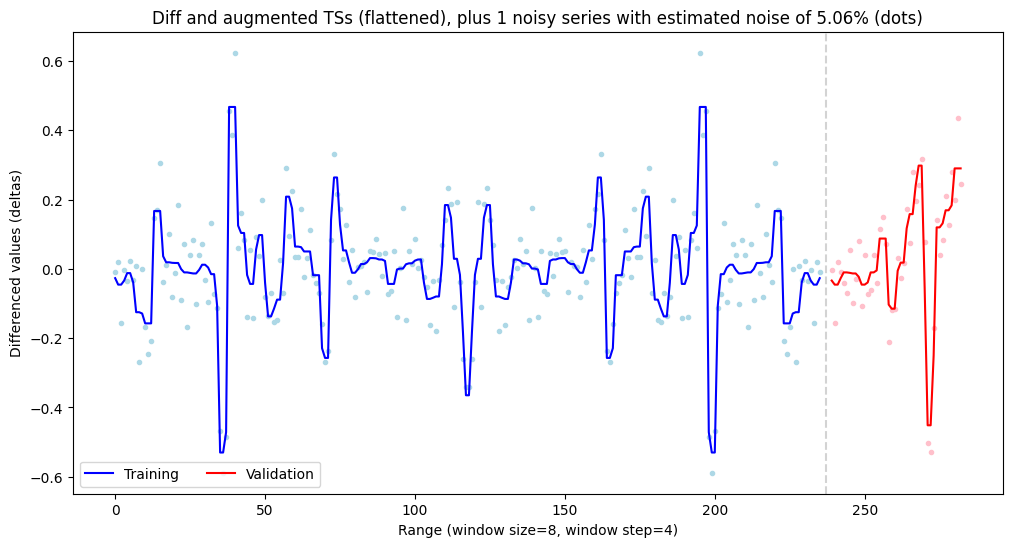

In [10]:
itg_diffaug_plot(y_train_enc, y_valid_enc, y_train_noisy_enc, y_valid_noisy_enc, wind_step, noise, noise_reps,
                 xlabel=f'Range (window size={wind_size}, window step={wind_step})',
                 ylabel='Differenced values (deltas)')

## Building and training a Quantum Autoencoder

In [11]:
### Libraries used in QAE development

# PennyLane imports
import pennylane as qml
from pennylane import numpy as np

# Pytorch imports
import torch
from torch import nn, tensor, optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

### QAE training parameters

In [12]:
### Main architectural params
n_layers = 2
n_extra = 0 # 3
n_latent = 7

n_trash = wind_size - n_latent
rot = 'Rxyz' # Ry Rxyz

### Other params
diff_method = 'best'
interface='torch'
expansion_strategy='gradient'
shuffle_interv = 0 # 20
log_interv = 5 # 10
cost_type = 'L1' # torch
cost_yscale = 'linear' # linear, log
epochs = 400 # 2000
shots = 100 # 1000
seed = 2024

In [13]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
TRAIN_PREF = f'{DATA_NAME}_{CASE_NAME}_n{samples}_w{wind_size}_ws{wind_step}_z{noise}_zr{noise_reps}_{rot}_lays{n_layers}_lat{n_latent}_tr{n_trash}_xq{n_extra}'
TRAIN_PREF

'beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0'

In [68]:
### Training info files 
train_info_default_fpath = f'{TRAIN_PATH}/info.json'
train_info_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_info.json'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_init.qnn'
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_hist{epochs}.json'
model_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_last_model.qnn'
params_fpath = f'{PARAMS_PATH}/{TRAIN_PREF}_model.qnn'
hist_chart_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_hist{epochs}.eps'
train_info_fpath

'beer_pl/training/beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0_info.json'

### Simulator device

In [15]:
### Find what devices are available

# Quantum simulator
sim = 'lightning.qubit' # default.qubit lightning.qubit lightning.gpu

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch_device = "cpu"
(sim, torch_device)

('lightning.qubit', 'cpu')

## Definine, train and test a model
*Note that the trainnig model will be used further, however, the testting model is used only as a reference for its structural properties. The actual testing models will be generated dynamically.*

### Pytorch utilities 

In [16]:
### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Gets all pytorch parameters
def get_param_vals(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    params = params.cpu().detach().flatten() # [0]
    return params.numpy()

### Prepare data for torch use

In [17]:
y_train_tens = torch.from_numpy(y_train_enc).to(torch_device)
y_valid_tens = torch.from_numpy(y_valid_enc).to(torch_device)
y_train_noisy_tens = torch.from_numpy(y_train_noisy_enc).to(torch_device)
y_valid_noisy_tens = torch.from_numpy(y_valid_noisy_enc).to(torch_device)

### Functions to create and train a model

In [18]:
### Full-QAE wrapper with a static data structure and variant input and weights only
def hybrid_qae_in(wires, n_latent, n_trash, n_extra, n_layers=1, rot='Ry'):
    def _hybrid_qae_in(inputs, weights):
        # inputs: Size of n_latent+n_trash
        # outputs: size of n_latent
        nonlocal wires, n_latent, n_trash, n_extra, n_layers, rot
        latent_wires = wires[0:n_latent]
        trash_wires = wires[n_latent:n_latent+n_trash]
        data_wires = latent_wires + trash_wires
        qml.AngleEmbedding(inputs, rotation='Y', wires=data_wires)
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, rotation=qml.RY, wires=wires)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=wires)
        return [qml.expval(qml.PauliZ(wires=w)) for w in latent_wires]
        # return qml.probs(wires=latent_wires)
    return _hybrid_qae_in

def hybrid_qae_out(wires, n_latent, n_trash, n_extra, n_layers=1, rot='Ry'):
    def _hybrid_qae_out(inputs, weights):
        # inputs: Size of n_latent
        # outputs: size of n_latent+n_trash
        nonlocal wires, n_latent, n_trash, n_extra, n_layers, rot
        latent_wires = wires[0:n_latent]
        trash_wires = wires[n_latent:n_latent+n_trash]
        data_wires = latent_wires + trash_wires
        qml.AngleEmbedding(inputs, rotation='Y', wires=latent_wires)
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, rotation=qml.RY, wires=wires)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=wires)
        return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]
        # return qml.probs(wires=data_wires)
    return _hybrid_qae_out

def hybrid_qae_shape(n_latent, n_trash, n_extra, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

In [19]:
### Testing full-QAE

# Define full-QAE parameters
test_latent = 3; test_trash = 2; test_extra = 1; test_layers=2
test_inputs = test_latent+test_trash
test_wires = test_latent+test_trash+test_extra
test_rot = 'Rxyz'
wires = list(range(test_wires))

weights_shape = hybrid_qae_shape(test_latent, test_trash, test_extra, n_layers=test_layers, rot=test_rot)
test_weights = np.prod(weights_shape)
print(f'QAE weight shape: {weights_shape}\n')

QAE weight shape: (2, 6, 3)



Data (torch.Size([5])): 
tensor([100., 125., 150., 175., 200.])

Weights (torch.Size([2, 6, 3])): 
tensor([[[0.6499, 0.3869, 0.4747],
         [0.1866, 0.4840, 0.6976],
         [0.1933, 0.9842, 0.4226],
         [0.4294, 0.4179, 0.4517],
         [0.5361, 0.2626, 0.7682],
         [0.5718, 0.0011, 0.3951]],

        [[0.6110, 0.9003, 0.6854],
         [0.5626, 0.1028, 0.6736],
         [0.5278, 0.5759, 0.7551],
         [0.8590, 0.7264, 0.3343],
         [0.6931, 0.7865, 0.4477],
         [0.9975, 0.9370, 0.5586]]], requires_grad=True)



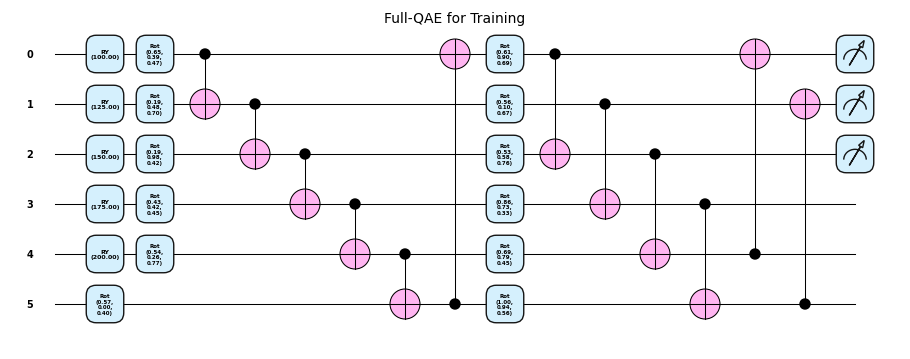

In [20]:
### Test QAE In

# Prepare test data
data_in = torch.linspace(100, 200, test_inputs, requires_grad=False)
weights_in = torch.rand(weights_shape, requires_grad=True)

print(f'Data ({data_in.shape}): \n{data_in}\n')
print(f'Weights ({weights_in.shape}): \n{weights_in}\n')

# Define a static full-QAE
qae_in = hybrid_qae_in(wires, test_latent, test_trash, test_extra, n_layers=test_layers, rot=test_rot)

# Create and draw a full-QAE
dev = qml.device(sim, wires=test_wires, shots=shots)
qae_in_qc = qml.QNode(qae_in, dev, interface='torch', expansion_strategy='gradient')
draw_circuit(qae_in_qc, scale=0.5, title='Full-QAE for Training', expansion_strategy='device') \
    (data_in, weights_in) # expansion_strategy='device'/'gradient'

Data (torch.Size([3])): 
tensor([100., 150., 200.])

Weights (torch.Size([2, 6, 3])): 
tensor([[[0.7437, 0.8876, 0.9114],
         [0.6987, 0.0601, 0.1771],
         [0.9150, 0.7600, 0.7229],
         [0.6629, 0.4603, 0.5593],
         [0.1243, 0.4123, 0.2718],
         [0.4559, 0.5663, 0.4032]],

        [[0.4101, 0.8749, 0.7628],
         [0.6614, 0.3451, 0.2055],
         [0.1449, 0.4932, 0.8329],
         [0.0569, 0.7822, 0.8902],
         [0.1107, 0.4932, 0.3095],
         [0.1919, 0.8565, 0.2338]]], requires_grad=True)



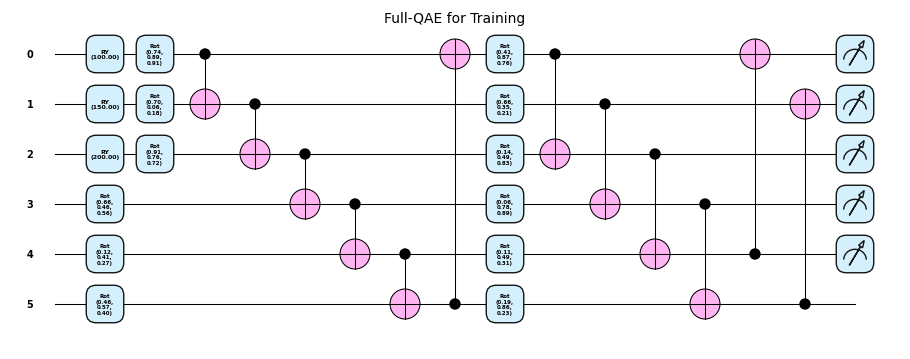

In [21]:
### Test QAE Out

# Prepare test data
data_out = torch.linspace(100, 200, test_latent, requires_grad=False)
weights_out = torch.rand(weights_shape, requires_grad=True)

print(f'Data ({data_out.shape}): \n{data_out}\n')
print(f'Weights ({weights_out.shape}): \n{weights_out}\n')

# Define a static full-QAE
qae_out = hybrid_qae_out(wires, test_latent, test_trash, test_extra, n_layers=test_layers, rot=test_rot)

# Create and draw a full-QAE
dev = qml.device(sim, wires=test_wires, shots=shots)
qae_out_qc = qml.QNode(qae_out, dev, interface='torch', expansion_strategy='gradient')
draw_circuit(qae_out_qc, scale=0.5, title='Full-QAE for Training', expansion_strategy='device') \
    (data_out, weights_out) # expansion_strategy='device'/'gradient'

In [22]:
### Hybrid autoencoder
class Autoencoder_hybrid(nn.Module):

    def __init__(self, sim, n_latent, n_trash, n_extra, n_layers=1, rot='Ry'):
        super(Autoencoder_hybrid, self).__init__()

        n_inputs = n_latent+n_trash
        n_outputs = n_latent+n_trash
        n_wires = n_latent+n_trash+n_extra
        wires = list(range(n_wires))

        ### Define QAE circuit weight shapes
        weights_shape = {"weights": hybrid_qae_shape(n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot)}

        ### Define QAE encoder

        # Encoder circuit and node
        qin = hybrid_qae_in(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot)
        dev = qml.device(sim, wires=n_wires) #, shots=shots)
        qin_node = qml.QNode(qin, dev, interface='torch', expansion_strategy='gradient')
        
        # Encoder layers and model
        qin_layer = qml.qnn.TorchLayer(qin_node, weights_shape)
        cin_layer = torch.nn.Linear(n_latent, n_latent)
        in_layers = [qin_layer, cin_layer]
        self.encode = nn.Sequential(*in_layers)        
        
        ### Define QAE decoder

        # Decoder circuit and node
        qout = hybrid_qae_out(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot)
        dev = qml.device(sim, wires=n_wires, shots=shots)
        qout_node = qml.QNode(qout, dev, interface='torch', expansion_strategy='gradient')

        # Decoder layers and model
        qout_layer = qml.qnn.TorchLayer(qout_node, weights_shape)
        cout_layer = torch.nn.Linear(n_outputs, n_outputs)
        out_layers = [qout_layer, cout_layer]
        self.decode = nn.Sequential(*out_layers)
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [23]:
### Classic autoencoder
class Autoencoder_classic(nn.Module):

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder_classic, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape),
            nn.Linear(enc_shape, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [24]:
### Trains the classical AE model
def train(model, error, optimizer, epochs, x, log_interv=100, prompt_fract=0.1):
    history = []
    min_epoch = 0
    min_loss = 1000
    opt_params = {}
    hist_params = []
    running_loss = 0
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(x)
        loss = error(output, x)
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        if curr_loss < min_loss: 
            min_loss = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if epoch % log_interv == 0:
            history.append(curr_loss)
            hist_params.append(copy.deepcopy(model.state_dict()))

        if epoch % int(prompt_fract*epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
            
        running_loss += curr_loss

    return history, opt_params, hist_params, (min_epoch, min_loss)

In [25]:
### Trains the AE with noisy input and clean output
def train_with_noise(model, error, optimizer, epochs, x_noisy, y_pure, log_interv=100, prompt_fract=0.1):
    history = []
    min_epoch = 0
    min_loss = 1000
    opt_params = {}
    hist_params = []
    running_loss = 0
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(x_noisy)
        loss = error(output, y_pure)
        loss.backward()
        optimizer.step()
        
        curr_loss = loss.item()
        if curr_loss < min_loss: 
            min_loss = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if epoch % log_interv == 0:
            history.append(curr_loss)
            hist_params.append(copy.deepcopy(model.state_dict()))

        if epoch % int(prompt_fract*epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
            
        running_loss += curr_loss

    return history, opt_params, hist_params, (min_epoch, min_loss)

In [26]:
### Remind the QAE params
print(f'n_layers = {n_layers}, n_latent = {n_latent}, n_trash = {n_trash}, n_extra = {n_extra}, rot = "{rot}"')

n_layers = 2, n_latent = 7, n_trash = 1, n_extra = 0, rot = "Rxyz"


In [27]:
### Set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
hqc_ae = Autoencoder_hybrid(sim, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)

### Loss and optimiser

# error = nn.MSELoss()
error = nn.L1Loss()

# optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
optimizer = optim.Adam(hqc_ae.parameters())

### Show 
hqc_ae.eval()

Autoencoder_hybrid(
  (encode): Sequential(
    (0): <Quantum Torch Layer: func=_hybrid_qae_in>
    (1): Linear(in_features=7, out_features=7, bias=True)
  )
  (decode): Sequential(
    (0): <Quantum Torch Layer: func=_hybrid_qae_out>
    (1): Linear(in_features=8, out_features=8, bias=True)
  )
)

In [28]:
### Train the model
start = time.time()

# cuda Fit (58 samples, 5+3=8 window, 19479 params, 30000 epochs): 0.01196 min cost @ iter# 27561, 19.62 sec

sel_noisy_rec = 0
history, opt_params, hist_params, opt_point = \
    train_with_noise(hqc_ae, error, optimizer, epochs, y_train_noisy_tens[sel_noisy_rec], y_train_tens, log_interv=log_interv, prompt_fract=0.05)

elapsed = time.time() - start

# Print run statistics
print(f'\n'+
      f'{sim} & {torch_device} Fit ('+
      f'{y_train_tens.shape[0]} samples, '+
      f'{n_latent}+{n_trash}={wind_size} window, '+
      f'{count_params(hqc_ae)} params, '+
      f'{epochs} epochs): '+
      f'{round(opt_point[1], 5)} min cost @ iter# {opt_point[0]}, '+
      f'{elapsed:0.2f} sec'+
      f'\n'
     )

epoch 0 	 Loss: 0.2406
epoch 20 	 Loss: 0.2187
epoch 40 	 Loss: 0.1997
epoch 60 	 Loss: 0.1764
epoch 80 	 Loss: 0.1596
epoch 100 	 Loss: 0.1495
epoch 120 	 Loss: 0.1313
epoch 140 	 Loss: 0.1231
epoch 160 	 Loss: 0.1172
epoch 180 	 Loss: 0.1068
epoch 200 	 Loss: 0.1058
epoch 220 	 Loss: 0.1032
epoch 240 	 Loss: 0.104
epoch 260 	 Loss: 0.1006
epoch 280 	 Loss: 0.09969
epoch 300 	 Loss: 0.1001
epoch 320 	 Loss: 0.1008
epoch 340 	 Loss: 0.0971
epoch 360 	 Loss: 0.0984
epoch 380 	 Loss: 0.09534

lightning.qubit & cpu Fit (58 samples, 7+1=8 window, 224 params, 400 epochs): 0.09357 min cost @ iter# 386, 4110.31 sec



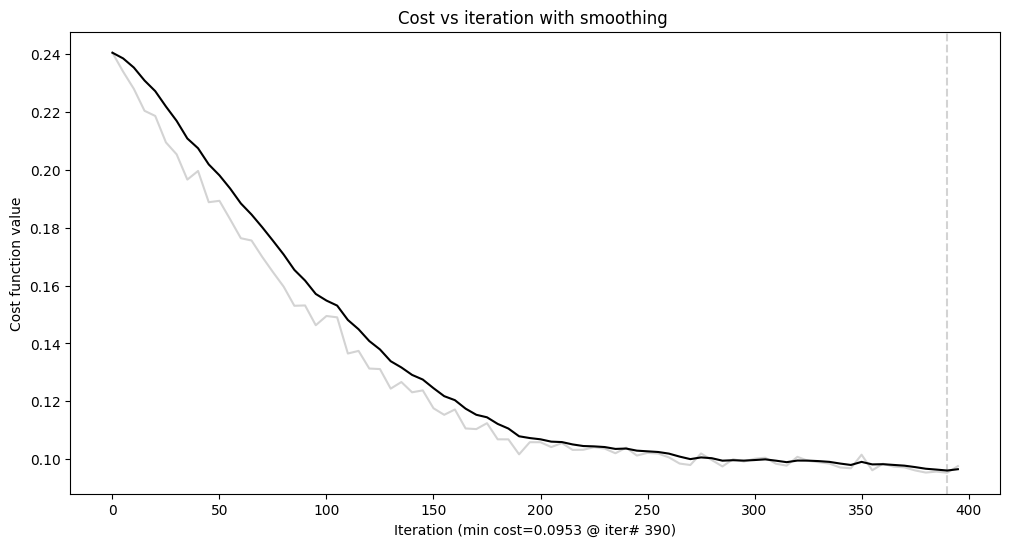

In [37]:
cost_plot(history, rcParams=(12, 6), backplot=True, back_color='lightgray', smooth_weight=0.7, log_interv=log_interv, 
          save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_hist{epochs}.eps')

In [30]:
# Models structures

print(f'Encoder characteristics: \n\n'+
      f'\ttraining windows={len(y_train_enc)}\n'+
      f'\tvalidation windows={len(y_valid_enc)}\n'+
      f'\tinputs={wind_size}\n'+
      f'\tweights={count_params(hqc_ae)}\n'+
      f'\tlatent layer={n_latent}\n'+
      f'\ttrash layer={n_trash}\n'+
      f'\tlayers={n_layers}\n'+
      f'\trot="{rot}"\n'+
      f'\tnoise={noise}\n'+
      f'\tnoise repeats={noise_reps}\n'+
      f'\n'+
      f'\tshuffle interv={shuffle_interv}\n'+
      f'\tlog interv={log_interv}\n'+
      f'\tcost type={cost_type}\n'+
      f'\tcost yscale={cost_yscale}\n'+
      f'\tsamples={y_train_enc.shape[0]}\n'+
      f'\tPennyLane simulator={sim}\n'+
      f'\tTorch device={torch_device}\n'+
      f'\tepochs={epochs}\n'+
      f'\tshots={shots}\n'+
      ''
     )


Encoder characteristics: 

	training windows=58
	validation windows=10
	inputs=8
	weights=224
	latent layer=7
	trash layer=1
	layers=2
	rot="Rxyz"
	noise=0.03
	noise repeats=1

	shuffle interv=0
	log interv=5
	cost type=L1
	cost yscale=linear
	samples=58
	PennyLane simulator=lightning.qubit
	Torch device=cpu
	epochs=400
	shots=100



## Saving the model
Note that all components of a test circuit will be built in the testing process

### Save info details

In [60]:
### Grab optimiser edtails
opt_name = optimizer.__class__.__name__
actual_epochs = len(history)*log_interv

### Save training parameters
train_info = \
    {'data_name':DATA_NAME,
     'case_name':CASE_NAME, 
     'major_version':major_version, 
     'minor_version':minor_version,
     'n_layers':n_layers,
     'n_latent':n_latent, 
     'n_trash':n_trash, 
     'n_extra':n_extra,
     'rot':rot,
     'cost_type':cost_type, 
     'cost_yscale':cost_yscale,
     'shuffle_interv':shuffle_interv,
     'log_interv':log_interv,
     'opt_name':opt_name,
     'epochs':actual_epochs,
     'shots':shots,
     'seed':seed}

### Saving the info file
write_json_file(train_info_fpath, train_info)
write_json_file(train_info_default_fpath, train_info)
    
print(f'\nSaved time series info in file "{train_info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()


Saved time series info in file "beer_pl/training/beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0_info.json":

	info[data_name] = beer
	info[case_name] = torpl
	info[major_version] = 4
	info[minor_version] = 2
	info[n_layers] = 2
	info[n_latent] = 7
	info[n_trash] = 1
	info[n_extra] = 0
	info[rot] = Rxyz
	info[cost_type] = L1
	info[cost_yscale] = linear
	info[shuffle_interv] = 0
	info[log_interv] = 5
	info[opt_name] = Adam
	info[epochs] = 400
	info[shots] = 100
	info[seed] = 2024



### Saving the loss history, selected parameters and the optimum params
Optimum parameters are for training - not validation)

In [71]:
print(f'Files to be saved (when True)\n')
print(f'Optimisation init point: {init_fpath}')
print(f'History of Cost:         {history_fpath}')
print(f'Optimisation parameters: {params_fpath}')
print(f'Last model:              {model_fpath}')
print()

Files to be saved (when True)

Optimisation init point: beer_pl/training/beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0_init.qnn
History of Cost:         beer_pl/training/beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0_hist400.json
Optimisation parameters: beer_pl/params/beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0_model.qnn
Last model:              beer_pl/training/beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0_last_model.qnn



**Note:** *the torch model parameters can be loaded into the model with: 
model.load_state_dict(torch.load(PATH))*

In [70]:
### Save the initial point, also save the history file
to_be_saved_starting_point = True

print()
if to_be_saved_starting_point:
    ### Saving the initialisation point
    torch.save(opt_params, f'{init_fpath}')
    print(f'Saved optimum parameters as the future starting point in:\n\t{init_fpath}')

    ### Saving the history file
    write_json_file(f'{history_fpath}', history)
    print(f'Saved optimisation history in:\n\t{history_fpath}')

    ### Saving all optimisation params
    params_parent_fpath = path.abspath(os.path.join(params_fpath, os.pardir))
    param_info = \
        {'case_name':CASE_NAME, 
         'major_version':major_version, 
         'minor_version':minor_version,
         'log_interv':log_interv,
         'log_number':len(hist_params)}
    write_json_file(f'{params_parent_fpath}/info.json', param_info) # Last
    write_json_file(f'{params_fpath[:-4]}_info{params_fpath[-4:]}', param_info)
    for next_params_no in range(len(hist_params)):
        next_param_pname = f'{params_fpath[:-4]}_{next_params_no:04d}{params_fpath[-4:]}'
        torch.save(hist_params[next_params_no], f'{next_param_pname}')
    print(f'Saved all optimisation parameters in files:\n\t{params_fpath[:-4]}_xxxx{params_fpath[-4:]}')

    ### Saving the last model parameters
    torch.save(hqc_ae.state_dict(), f'{model_fpath}')
    print(f'Saved the last model in:\n\t{model_fpath}')

else:
    print(f'Parameters and history not saved') 
print()


Saved optimum parameters as the future starting point in:
	beer_pl/training/beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0_init.qnn
Saved optimisation history in:
	beer_pl/training/beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0_hist400.json
Saved all optimisation parameters in files:
	beer_pl/params/beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0_model_xxxx.qnn
Saved the last model in:
	beer_pl/training/beer_torpl_n160_w8_ws4_z0.03_zr1_Rxyz_lays2_lat7_tr1_xq0_last_model.qnn



## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

4. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021

# Software in use

In [34]:
!conda env list

# conda environments:
#
base                     /home/jacob/miniconda3
pl                       /home/jacob/miniconda3/envs/pl
pl-cuda12             *  /home/jacob/miniconda3/envs/pl-cuda12
qiskit                   /home/jacob/miniconda3/envs/qiskit
qiskit-gpu               /home/jacob/miniconda3/envs/qiskit-gpu
qiskit100                /home/jacob/miniconda3/envs/qiskit100



In [35]:
!pip list | grep -E 'PennyLane|torch'

PennyLane                 0.36.0
PennyLane_Lightning       0.36.0
PennyLane_Lightning_GPU   0.36.0
PennyLane-Rigetti         0.36.0
torch                     2.3.1+cu121
torchaudio                2.3.1+cu121
torchsummary              1.5.1
torchvision               0.18.1+cu121
